In [4]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

import matplotlib as mpl

from cassL import camb_interface as ci
from cassL import generate_emu_data as ged
from cassL import user_interface as ui

pb.ion()

file_base = ""

In [5]:
#assert False, "you should give this emulator a new name instead of over-writing"
# Emulator version label, for plots
emu_vlabel = "Hnu2"

In [6]:
X_orig = np.load("../../best_lhc_unit_Hnu2_test.npy", allow_pickle=True)
X_orig = X_orig[:100]
X_orig[:, 3]
sigma12s = np.sqrt(X_orig[:, 3] * 0.96 + 0.04)

In [7]:
len(sigma12s)

100

(array([ 6.,  6.,  5., 14., 17.,  8., 11., 13., 11.,  9.]),
 array([0.20684294, 0.28571124, 0.36457955, 0.44344785, 0.52231616,
        0.60118446, 0.68005277, 0.75892107, 0.83778938, 0.91665769,
        0.99552599]),
 <BarContainer object of 10 artists>)

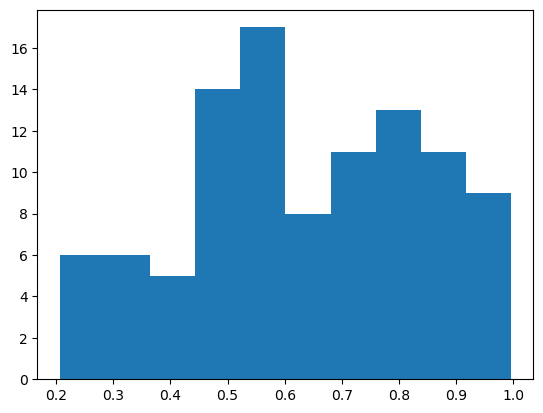

In [8]:
pb.hist(sigma12s)

In [9]:
#X_raw = np.load("G_versions/hc_G6_test.npy", allow_pickle=True)
#Y_raw = np.load("G_versions/samples_G6_test.npy", allow_pickle=True)
linear_in_sigma12 = False

# We don't use the emu_vlabel variable in the following code because the lhc
# version has decoupled from the emulator version.
if linear_in_sigma12:
    X_raw = np.load("hc_backup_i99_H3_unit_train.npy", allow_pickle=True)
    Y_raw = np.load("samples_backup_i99_H3_unit_train.npy", allow_pickle=True)
else:
    # X_raw = np.load("hc_backup_i499_H2_train.npy", allow_pickle=True)
    # Y_raw = np.load("samples_backup_i499_H2_train.npy", allow_pickle=True)
    X_raw = np.load("lhc_unit_H2_test.npy", allow_pickle=True)
    Y_raw = np.load("samples_unit_H2_test.npy", allow_pickle=True)  

In [10]:
scales = np.load("standard_k.npy", allow_pickle=True)

In [11]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [12]:
m = pickle.load(open("analyses/massive_emulator_" + emu_vlabel + ".cle", "rb"))

In [13]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * m.ystdev + m.ymu)

In [14]:
par_ranges = ui.get_param_ranges(massive_neutrinos=True)
xmin = np.array([])
xrange = np.array([])

for key in par_ranges.keys():
    xmin = np.append(xmin, par_ranges[key][0])
    xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])

# ! This is bad form, xmin and xrange should be saved with the emulator object
#def xtransform(configuration):
#    return (configuration - xmin) / xrange

def xtransform(configuration):
    return configuration

In [15]:
def nest(array):
    return np.array([np.array(array)])

In [16]:
preds = np.zeros(Y.shape)
rel_errors = np.zeros(Y.shape)
sq_errors = np.zeros(Y.shape)
deltas = np.zeros(Y.shape)

for i in range(len(X)):
    x = xtransform(nest(X[i]))
    raw_pred, _ = m.predict(x)
    preds[i] = inverse_ytransform(raw_pred)
    deltas[i] = preds[i] - Y[i]
    rel_errors[i] = deltas[i] / Y[i]
    sq_errors[i] = np.square(deltas[i])
    
rel_errors = deltas

In [17]:
print("Squared error across all models:")
print(sum(sum(sq_errors)))

Squared error across all models:
73902534183.22797


# An example of an extreme error plot, with the cosmology it was
# supposed to describe. 

pb.plot(rel_errors[900] * 100)
print(X[900])

In [18]:
min(X[:, 3])

9.999952636516665e-05

In [19]:
max(X[:, 3])

0.9999002927300352

In [20]:
def normalize(array):
    min_ = min(array)
    max_ = max(array)
    range_ = max_ - min_
    shifted = array - min_
    return shifted / range_

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

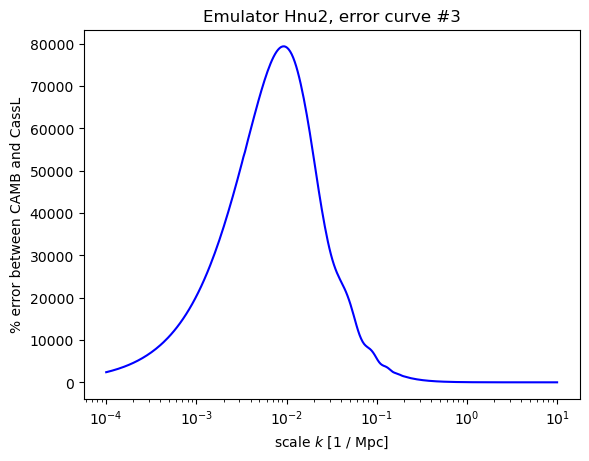

In [21]:
error_i = 3
pb.plot(scales, 100 * rel_errors[error_i], color='blue')
pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", error curve #" + str(error_i))
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G7a.png")

In [22]:
# Let's use the plasma color map
def plot_colored_errors(param_index, param_label, param_range=None,
    save_label=None):
    valid_indices = list(range(len(X[:, param_index])))
    if param_range is not None:
        valid_indices = np.where(np.logical_and(
            X[:, param_index] < param_range[1],
            X[:, param_index] > param_range[0]))[0]
    valid_vals = X[:, param_index][valid_indices]
    normalized_vals = normalize(valid_vals)
    # normalized_vals = normalize(X[:, param_index])
    colors = pb.cm.plasma(normalized_vals)
    valid_errors = rel_errors[valid_indices]
    
    for i in range(len(valid_errors)):
        if i % 1 == 0:
            pb.plot(scales, valid_errors[i],
                color=colors[i], alpha=0.05)
            pb.xscale('log')

    pb.title(r"Emulator " + emu_vlabel + ", " + str(len(valid_errors)) + \
             r" Random Massive-$\nu$ Models" + "\ncolored by " + \
             param_label + " value")
    pb.ylabel("% error between CAMB and CassL")
    pb.xlabel("scale $k$ [1 / Mpc]")
    norm = mpl.colors.Normalize(
        vmin=min(X[:, param_index][valid_indices]),
        vmax=max(X[:, param_index][valid_indices]))
    pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma, norm=norm))
    # Momentarily eliminate saving so that we don't keep crashing on the
    # incomplete file handles.
    if save_label is not None:
        pb.savefig("../plots/emulator/performance/" + save_label + ".png")

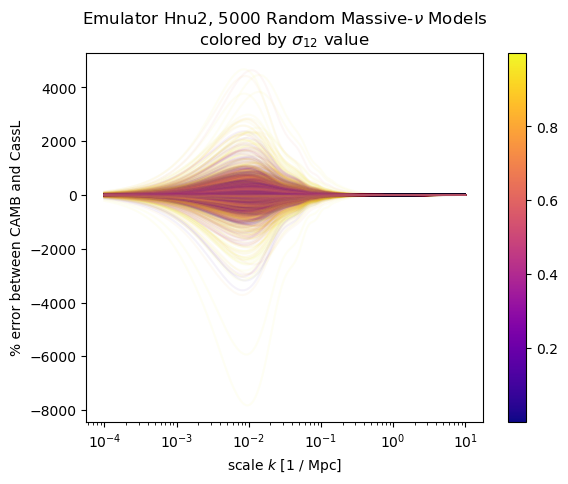

In [23]:
plot_colored_errors(3, r"$\sigma_{12}$", save_label="s12_coloration")

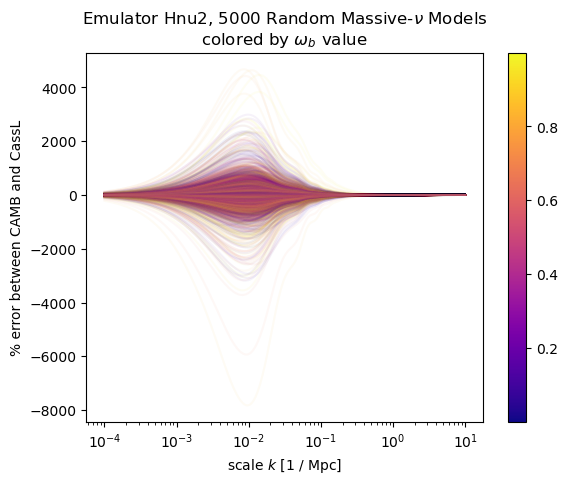

In [24]:
plot_colored_errors(0, r"$\omega_b$")

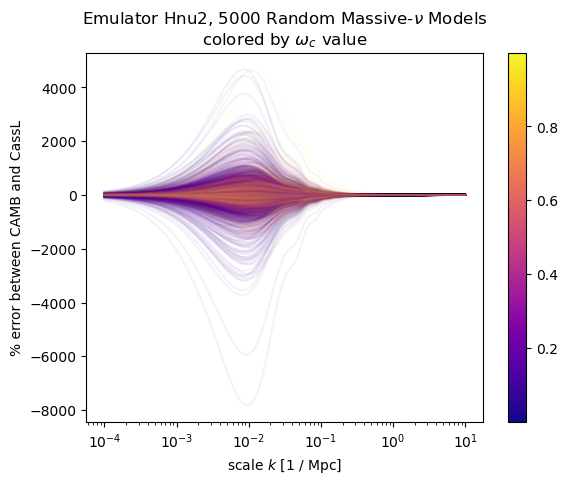

In [25]:
plot_colored_errors(1, r"$\omega_c$")

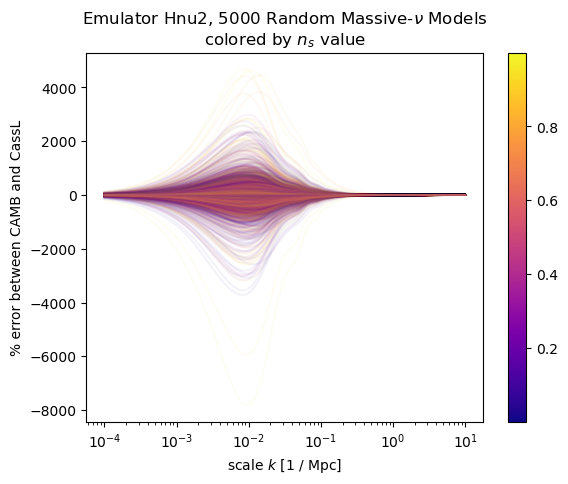

In [26]:
plot_colored_errors(2, r"$n_s$")

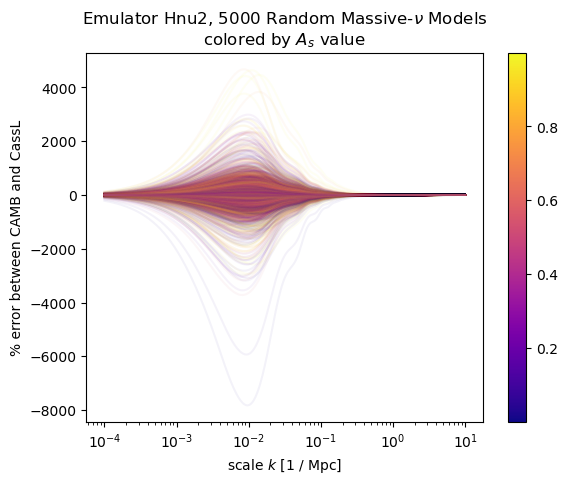

In [27]:
plot_colored_errors(4, r"$A_s$", save_label="_colored_by_As")

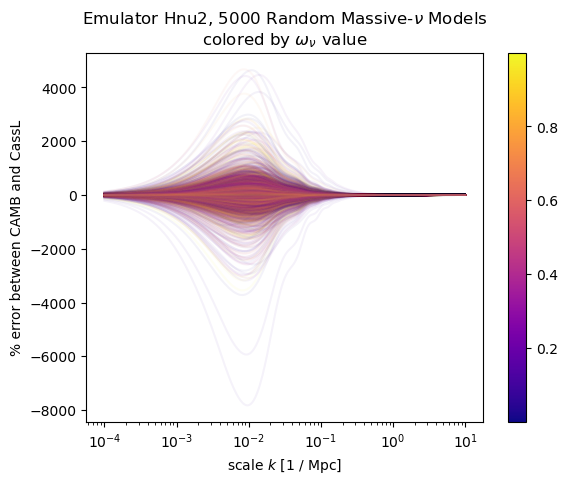

In [28]:
plot_colored_errors(5, r"$\omega_\nu$", save_label="_colored_by_omnu")

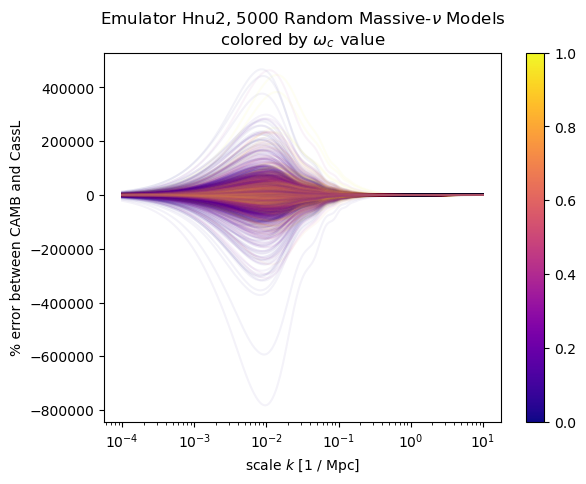

In [29]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

# Let's use the plasma color map
normalized_omc_vals = normalize(X[:, 1])
colors_omc = pb.cm.plasma(normalized_omc_vals)

for i in range(len(rel_errors)):
    if i % 1 == 0:
        pb.plot(scales, 100 * rel_errors[i],
            color=colors_omc[i], alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_c$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma))
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

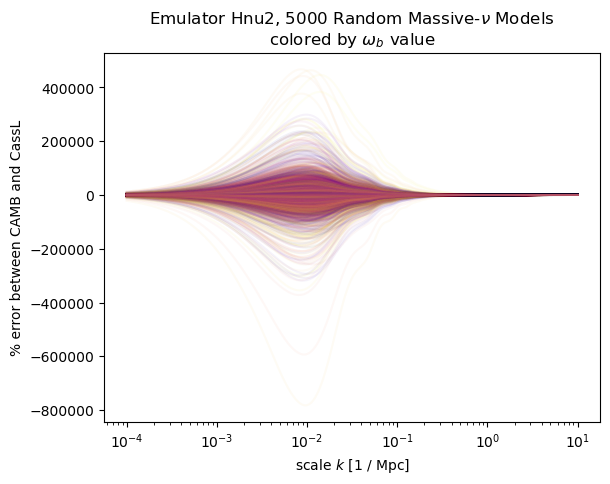

In [30]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color=pb.cm.plasma(X[i][0]), alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_b$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

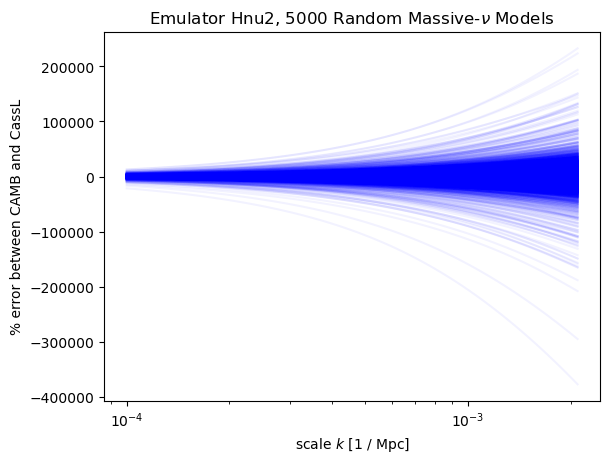

In [31]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales[:80], 100 * rel_errors[i][:80],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

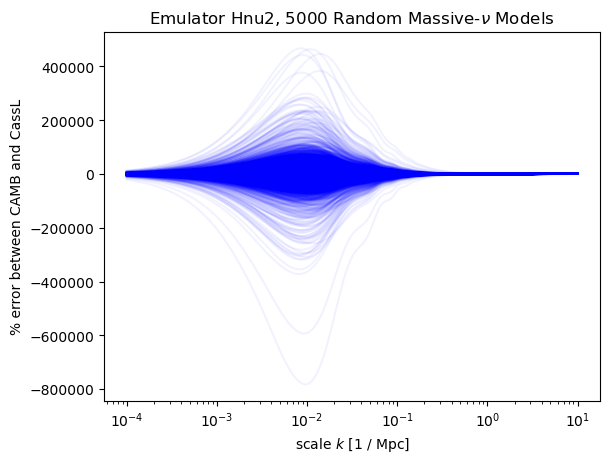

In [32]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.savefig("../plots/emulator/performance/massive_5k_" + emu_vlabel + ".png")

In [33]:
# Error statistics ideas: parentheticals describe building blocks

# (for each curve:)
    # a minimum percent error
    # b maximum percent error
    # c standard deviation of errors
    # d mean error
    # e median error

# Median, mean, stddev of a-e.

mins = np.array([min(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MINIMUM RELATIVE ERRORS:")
print("this ranges from", min(mins), "to", max(mins))
print("median is", np.median(mins))
print("mean is", np.mean(mins))
print("st.dev. is", np.std(mins))

MINIMUM RELATIVE ERRORS:
this ranges from 9.989853277936334e-08 to 0.033710927042138406
median is 0.0006953030856394204
mean is 0.0009497848069529514
st.dev. is 0.0011740681751633876


In [34]:
maxs = np.array([max(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MAXIMUM RELATIVE ERRORS:")
print("this ranges from", min(maxs), "to", max(maxs))
print("median is", np.median(maxs))
print("mean is", np.mean(maxs))
print("st.dev. is", np.std(maxs))

MAXIMUM RELATIVE ERRORS:
this ranges from 0.7067999633054569 to 7825.081165543845
median is 258.46296961240296
mean is 357.2212923808125
st.dev. is 412.273128135149


In [35]:
means = np.array([np.mean(rel_error_curve) for rel_error_curve in rel_errors])
print("MEAN RELATIVE ERRORS:")
print("this ranges from", min(means), "to", max(means))
print("median is", np.median(means))
print("mean is", np.mean(means))
print("st.dev. is", np.std(means))

MEAN RELATIVE ERRORS:
this ranges from -1959.51652321556 to 1171.9039505680726
median is -0.423954610779841
mean is 0.8079188471161928
st.dev. is 137.6669845857507


In [36]:
meds = np.array([np.median(rel_error_curve) for rel_error_curve in rel_errors])
print("MEDIAN RELATIVE ERRORS:")
print("this ranges from", min(meds), "to", max(meds))
print("median is", np.median(meds))
print("mean is", np.mean(meds))
print("st.dev. is", np.std(meds))

MEDIAN RELATIVE ERRORS:
this ranges from -655.3211929367471 to 405.30616624398317
median is -0.0005258283991577684
mean is 0.3045298247196021
st.dev. is 47.09886107362651


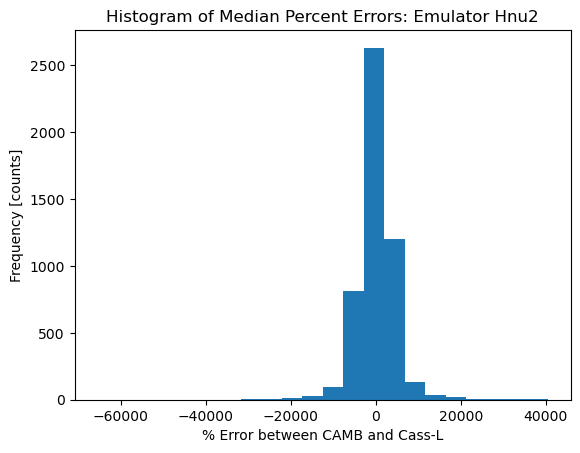

In [37]:
pb.hist(100 * meds, bins=22)
pb.title("Histogram of Median Percent Errors: Emulator " + emu_vlabel)
pb.ylabel("Frequency [counts]")
pb.xlabel("% Error between CAMB and Cass-L")
pb.savefig("../plots/emulator/performance/err_hist_" + emu_vlabel + ".png")

In [38]:
stddevs = np.array([np.std(rel_error_curve) for rel_error_curve in rel_errors])
print("ST.DEV.S IN RELATIVE ERRORS:")
print("this ranges from", min(stddevs), "to", max(stddevs))
print("median is", np.median(stddevs))
print("mean is", np.mean(stddevs))
print("st.dev. is", np.std(stddevs))

ST.DEV.S IN RELATIVE ERRORS:
this ranges from 0.23391552309253183 to 2483.9535789419374
median is 82.70473595605816
mean is 114.08783630538362
st.dev. is 131.52745094280172


(array([4.878e+03, 1.030e+02, 1.300e+01, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([9.98985328e-08, 3.37118261e-03, 6.74226533e-03, 1.01133480e-02,
        1.34844308e-02, 1.68555135e-02, 2.02265962e-02, 2.35976789e-02,
        2.69687616e-02, 3.03398443e-02, 3.37109270e-02]),
 <BarContainer object of 10 artists>)

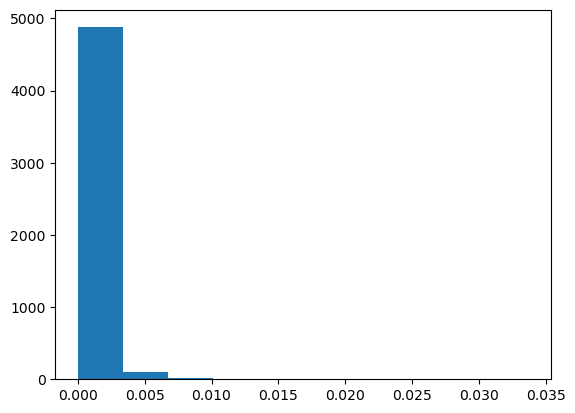

In [39]:
pb.hist(mins)

(array([4.598e+03, 3.020e+02, 6.200e+01, 2.600e+01, 6.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([7.06799963e-01, 7.83144237e+02, 1.56558167e+03, 2.34801911e+03,
        3.13045655e+03, 3.91289398e+03, 4.69533142e+03, 5.47776886e+03,
        6.26020629e+03, 7.04264373e+03, 7.82508117e+03]),
 <BarContainer object of 10 artists>)

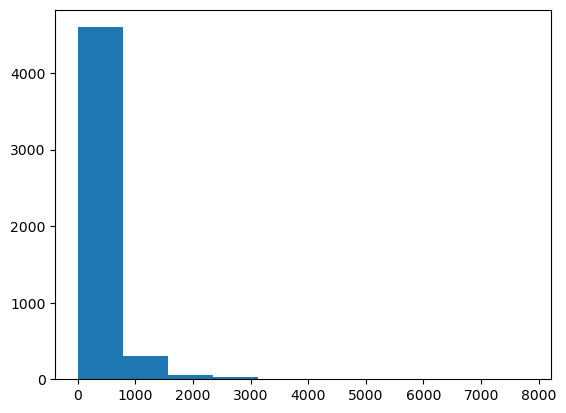

In [40]:
pb.hist(maxs)

(array([4.593e+03, 3.070e+02, 5.900e+01, 2.800e+01, 7.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([2.33915523e-01, 2.48605882e+02, 4.96977848e+02, 7.45349815e+02,
        9.93721781e+02, 1.24209375e+03, 1.49046571e+03, 1.73883768e+03,
        1.98720965e+03, 2.23558161e+03, 2.48395358e+03]),
 <BarContainer object of 10 artists>)

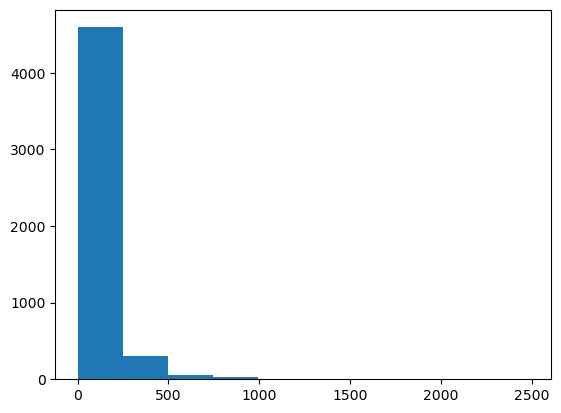

In [41]:
pb.hist(stddevs)

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.100e+01, 4.300e+01, 1.367e+03,
        3.460e+03, 9.400e+01, 1.800e+01, 5.000e+00]),
 array([-655.32119294, -549.25845702, -443.1957211 , -337.13298518,
        -231.07024926, -125.00751335,  -18.94477743,   87.11795849,
         193.18069441,  299.24343033,  405.30616624]),
 <BarContainer object of 10 artists>)

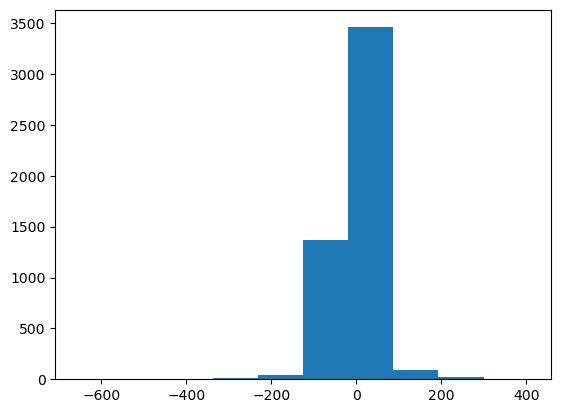

In [42]:
pb.hist(meds)

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+01, 3.500e+01, 9.450e+02,
        3.865e+03, 1.190e+02, 1.800e+01, 6.000e+00]),
 array([-1959.51652322, -1646.37447584, -1333.23242846, -1020.09038108,
         -706.9483337 ,  -393.80628632,   -80.66423895,   232.47780843,
          545.61985581,   858.76190319,  1171.90395057]),
 <BarContainer object of 10 artists>)

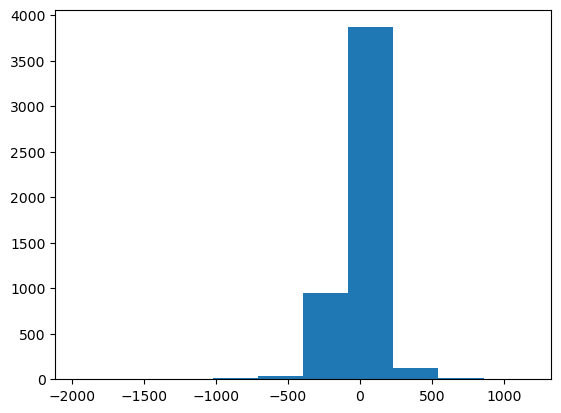

In [43]:
pb.hist(means)